# 神经网络和深度学习 —— 作业1 构建两层神经网络分类器
学号：22210980044     &ensp; &ensp; 姓名：金天姿
***


#### 至少包含以下三个部分：

#### 1.训练：
激活函数

反向传播，loss以及梯度的计算

学习率下降策略

L2正则化

优化器SGD

保存模型

 

#### 2.参数查找：学习率，隐藏层大小，正则化强度
 

#### 3.测试：导入模型，用经过参数查找后的模型进行测试，输出分类精度

#### 数据集：MNIST


In [2]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.datasets import mnist # 导入mnist数据集（tensorflow只用于导入数据集）
from sklearn.model_selection import train_test_split

## 1. 训练
# relu激活函数
def relu(x):
    return np.maximum(0, x)                            

# relu激活函数的梯度
def relu_grad(x):
    x = np.where(x>=0,1,0)
    return x

# softmax激活函数,用于输出层
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))

# 交叉熵函数（损失函数使用交叉熵函数+L2正则化）
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


# 两层神经网路：激活函数relu，损失函数交叉熵误差+L2正则化，输出层softmax，优化函数SGD
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,lambda_=0.0001, weight_init_std=0.01):
        # lambda_——正则化强度
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        self.lambda_ = lambda_

    def predict(self, x):
        # 预测
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    def L2_regularization(self,lambda_):
        # L2正则化
        W1, W2 = self.params['W1'], self.params['W2']
        l2_loss = 0.5 * lambda_ * (np.sum(W1 * W1)+np.sum(W2 * W2))
        return l2_loss

    def loss(self, x, t):
        # 损失函数（交叉熵函数+L2正则化）
        # x:输入数据, t:监督数据
        y = self.predict(x)
        return cross_entropy_error(y, t)+ self.L2_regularization(self.lambda_)

    def accuracy(self, x, t):
        # 准确率
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        # 使用误差的反向传播计算梯度
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # 向前
        a1 = np.dot(x, W1) + b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # 向后
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        da1 = np.dot(dy, W2.T)
        dz1 = relu_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads


Parameter Search:
----------------  learning rate:0.03,  hidden size:50,  L2 regularization intensity:0.1  ----------------
epoch:0,  iter:0,  train loss:2.50201,  test loss:2.50206,  train accuracy:0.06775,  test accuracy: 0.06467 
epoch:1,  iter:375,  train loss:1.78919,  test loss:1.75983,  train accuracy:0.78063,  test accuracy: 0.78092 
epoch:2,  iter:750,  train loss:2.13908,  test loss:2.12388,  train accuracy:0.86606,  test accuracy: 0.86908 
epoch:3,  iter:1125,  train loss:2.43534,  test loss:2.45277,  train accuracy:0.88738,  test accuracy: 0.88942 
epoch:4,  iter:1500,  train loss:2.71158,  test loss:2.69805,  train accuracy:0.89785,  test accuracy: 0.89967 
epoch:5,  iter:1875,  train loss:2.93236,  test loss:2.88689,  train accuracy:0.90440,  test accuracy: 0.90542 
epoch:6,  iter:2250,  train loss:3.07659,  test loss:3.05737,  train accuracy:0.90863,  test accuracy: 0.91025 
epoch:7,  iter:2625,  train loss:3.20257,  test loss:3.20476,  train accuracy:0.91171,  test accu

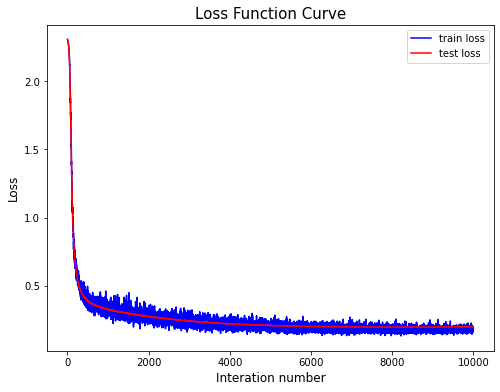

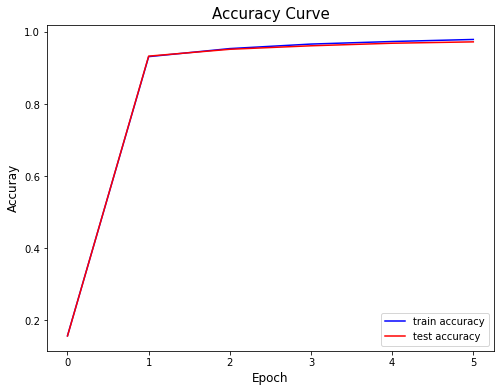

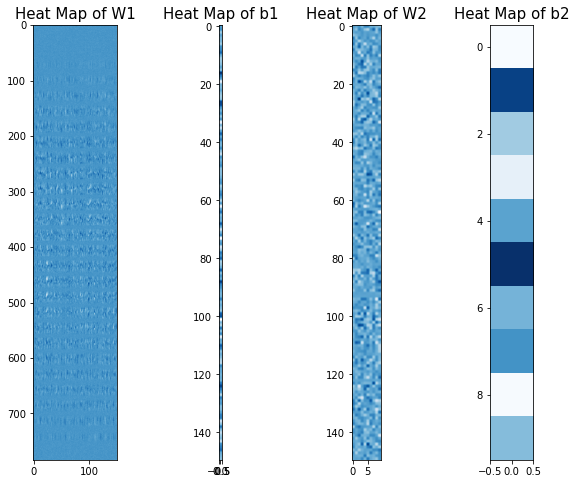

In [4]:
# 两层神经网络实现
def model(x_train, y_train, x_test, y_test, learning_rate, hidden_size,lambda_,iters_num,batch_size):
    choose_acc = []
    train_size = x_train.shape[0]
    # 导入模型
    network = TwoLayerNet(input_size=x_train.shape[1], hidden_size=hidden_size, output_size=y_train.shape[1],lambda_=lambda_)

    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch = 0

    #训练
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        y_batch = y_train[batch_mask]

        # 梯度
        grad = network.gradient(x_batch, y_batch)

        # 通过梯度更新参数
        for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]

        train_loss = network.loss(x_batch, y_batch)
        train_loss_list.append(train_loss)
        test_loss = network.loss(x_test, y_test)
        test_loss_list.append(test_loss)

        #每一个epoch打印训练和测试的准确率
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, y_train)
            test_acc = network.accuracy(x_test, y_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print("epoch:%.f,  iter:%.f,  train loss:%.5f,  test loss:%.5f,  train accuracy:%.5f,  test accuracy: %.5f "
                  %(epoch, i, train_loss, test_loss, train_acc, test_acc))
            epoch += 1

        # 输出最终的权重参数
        if i == iters_num-1:
            W1,W2 = network.params['W1'], network.params['W2']
            b1,b2 = network.params['b1'], network.params['b2']
    return train_loss_list,test_loss_list,train_acc_list,test_acc_list,W1,W2,b1,b2


## 2. 参数查找：学习率，隐藏层大小，正则化强度
def para_search(x_train, y_train, learning_rate_set, hidden_size_set,lambda_set,iters_num,batch_size):
    print("==========================================================================================================")
    print("Parameter Search:")
    # 在训练集中再划分训练集和验证集，用于调参
    x_train_train, x_train_val, y_train_train, y_train_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    
    choose_acc = []
    train_size = x_train_train.shape[0]
    for learning_rate in learning_rate_set: # 学习率
        for hidden_size in hidden_size_set: # 隐藏层大小
            for lambda_ in lambda_set: # 正则化强度
                print("----------------  learning rate:{},  hidden size:{},  L2 regularization intensity:{}  ----------------"
                      .format(learning_rate,hidden_size,lambda_))
                train_loss_list,test_loss_list,train_acc_list,test_acc_list,W1,W2,b1,b2 = model(x_train_train, y_train_train, x_train_val, y_train_val, learning_rate, hidden_size,lambda_,iters_num,batch_size)
                choose_acc.append([learning_rate,hidden_size,lambda_,test_acc_list[-1]])
    max_acc = 0
    learning_rate, hidden_size,lambda_ = 0,0,0
    for i in range(len(choose_acc)):
        if choose_acc[i][-1]>max_acc:
            learning_rate, hidden_size,lambda_ = choose_acc[i][0],choose_acc[i][1],choose_acc[i][2]
            max_acc = choose_acc[i][-1]
    print("==========================================================================================================")
    print("Choose Parameter: learning rate={}, hidden size={}, L2 regularization intensity={}, val accuracy={}"
          .format(learning_rate, hidden_size,lambda_,max_acc))
    print("==========================================================================================================")
    return learning_rate, hidden_size,lambda_


## 3. 测试
# one-hot编码
def one_hot(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
    return T

# 读入数据
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 #归一化
x_train = x_train.reshape(-1,784)  # flatten, (60000,28,28)变（60000,784）
x_test = x_test.reshape(-1,784)  # flatten, (10000,28,28)变（10000,784）
y_train = one_hot(y_train) #标签one-hot编码
y_test = one_hot(y_test) #标签one-hot编码

# 调参：学习率，隐藏层大小，正则化强度
iters_num=10000
batch_size=512
lambda_set = [0.1,0.01, 0.001] # 正则化强度参数范围
hidden_size_set = [50,100,150] # 隐藏层大小参数范围
learning_rate_set = [0.03,0.05,0.07]  # 学习率参数范围
learning_rate, hidden_size,lambda_ = para_search(x_train, y_train, learning_rate_set, hidden_size_set,lambda_set,iters_num,batch_size)

# 用经过参数查找后的模型进行测试
print("Test With The Model After Parameter Search:")
print("learning rate={}, hidden size={}, L2 regularization intensity={}".format(learning_rate, hidden_size,lambda_))
train_loss_list,test_loss_list,train_acc_list,test_acc_list,W1,W2,b1,b2 = model(x_train, y_train, x_test, y_test, learning_rate, hidden_size,lambda_,iters_num,batch_size)
print("==========================================================================================================")


# 结果可视化    
# 绘制loss曲线
plt.figure(figsize=(8,6))
plt.plot(train_loss_list, color='b', label="train loss")
plt.plot(test_loss_list, color='r', label="test loss")
plt.legend()
plt.title('Loss Function Curve',fontsize=15)
plt.xlabel('Interation number',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.show()

# 绘制Accuracy曲线
plt.figure(figsize=(8,6))
plt.plot(train_acc_list, color='b', label="train accuracy")
plt.plot(test_acc_list, color='r', label="test accuracy")
plt.title('Accuracy Curve',fontsize=15)
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Accuray',fontsize=12)
plt.legend()
plt.show()

# 绘制参数W1,W2,b1,b2的热力图
plt.figure(figsize=(10,8))
plt.subplot(1,4,1)
plt.imshow(W1, cmap='Blues')
plt.title('Heat Map of W1',fontsize=15)
plt.subplot(1,4,2)
plt.imshow(b1.reshape(len(b1),1), cmap='Blues')
plt.title('Heat Map of b1',fontsize=15)
plt.subplot(1,4,3)
plt.imshow(W2, cmap='Blues')
plt.title('Heat Map of W2',fontsize=15)
plt.subplot(1,4,4)
plt.imshow(b2.reshape(len(b2),1), cmap='Blues')
plt.title('Heat Map of b2',fontsize=15)
plt.show()